# EarlyStopping Callback
* Stops training after it can't improve anymore
# Data Pre-processing
* Normalization
* Regularization

# Scaling 
* Typical scaling
* Standardized scaling

### SciKit-Learn Functions MinMaxScaler and StandardScalar are used

In [107]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import plot_model
import keras
import numpy as np
from sklearn.model_selection import train_test_split as ts_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

plt.rcParams["figure.figsize"] = (10,5)
SEED = 42

In [108]:
data = pd.read_csv("./Datasets/insurance.csv")
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [109]:
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]),
    (OneHotEncoder(handle_unknown="ignore"), ["sex_male", "sex_female", "smoker_yes",
     "smoker_no", "region_northeast", "region_northwest", "region_southeast", "region_southwest"])
)

In [110]:
one_hot = pd.get_dummies(data)
X = one_hot.drop("charges", axis=1)  # add data without charges
Y = one_hot["charges"]  # add only charges data
X,Y

(      age     bmi  children  sex_female  sex_male  smoker_no  smoker_yes  \
 0      19  27.900         0        True     False      False        True   
 1      18  33.770         1       False      True       True       False   
 2      28  33.000         3       False      True       True       False   
 3      33  22.705         0       False      True       True       False   
 4      32  28.880         0       False      True       True       False   
 ...   ...     ...       ...         ...       ...        ...         ...   
 1333   50  30.970         3       False      True       True       False   
 1334   18  31.920         0        True     False       True       False   
 1335   18  36.850         0        True     False       True       False   
 1336   21  25.800         0        True     False       True       False   
 1337   61  29.070         0        True     False      False        True   
 
       region_northeast  region_northwest  region_southeast  region_southw

In [111]:
x, y = {"train": None,"test": None}, {"train": None,"test": None,}
x["train"], x["test"], y["train"], y["test"] = ts_split(X, Y, test_size=0.2, random_state=SEED)

[(len(x[key]),len(y[key])) for key in x.keys()], type(x["train"])

([(1070, 1070), (268, 268)], pandas.core.frame.DataFrame)

In [112]:
# Fit the column transformer to our training data
ct.fit(x["train"])
x_train_normal = ct.transform(x["train"])
x_test_normal = ct.transform(x["test"])


In [113]:
x["train"].loc[0],x_train_normal[0]

(age                    19
 bmi                  27.9
 children                0
 sex_female           True
 sex_male            False
 smoker_no           False
 smoker_yes           True
 region_northeast    False
 region_northwest    False
 region_southeast    False
 region_southwest     True
 Name: 0, dtype: object,
 array([0.60869565, 0.10734463, 0.4       , 1.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        1.        , 1.        , 0.        , 0.        , 1.        ,
        1.        , 0.        , 1.        , 0.        ]))

In [114]:
x["train"].shape,x_train_normal[0].shape

((1070, 11), (19,))

<Axes: ylabel='Frequency'>

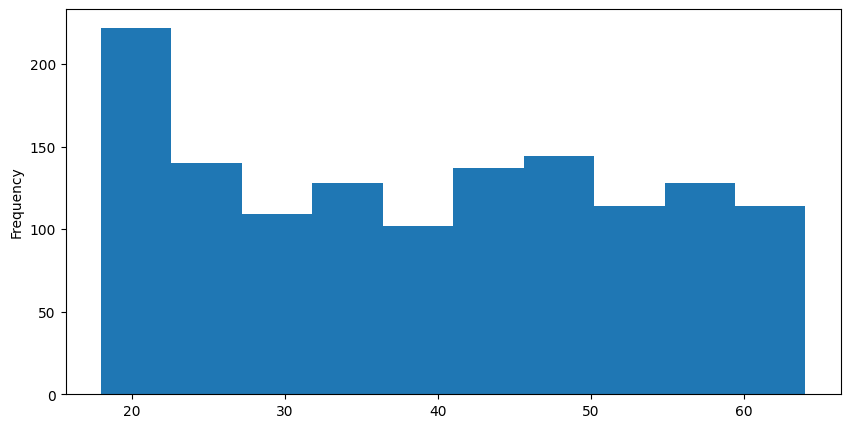

In [115]:
X["age"].plot(kind="hist") # Normalization

In [116]:
x["train"] = x_train_normal
x["test"] = x_test_normal

In [117]:
for key in x.keys():
    x[key], y[key] = np.asarray(x[key]).astype(np.float32), np.asarray(y[key]).astype(np.float32)
x["train"].shape, y["train"].shape

((1070, 19), (1070,))

In [118]:
class Model:

    def __init__(self, seed: int = 42, x=x, y=y):
        plt.rcParams["figure.figsize"] = (10, 5)
        tf.random.set_seed(seed)
        self.model = keras.Sequential()
        self.dataset_init(x,y)

    def dataset_init(self, x, y):
        self.x_train = x["train"]
        self.y_train = y["train"]
        self.x_test = x["test"]
        self.y_test = y["test"]
        ...

    def new_model(self, *hidden_units: int):
        # Input Layer
        input_shape = self.x_train.shape[1:]
        if input_shape is not None:
            self.model.add(keras.layers.InputLayer(input_shape=input_shape))
        else:
            self.model.add(keras.layers.InputLayer())
        # Hidden Layers
        for key in hidden_units:  # More flexible units and layers imporves the odel
            self.model.add(keras.layers.Dense(key, activation="relu"))
        # Output Layer
        self.model.add(keras.layers.Dense(1))

    def train(self,
              lr: float = 0.001,
              epochs: int = 100,
              verbose: int = 0):
        self.model.compile(loss=keras.losses.mae,
                           optimizer=keras.optimizers.Adam(learning_rate=lr),
                           metrics=["mae"])
        history = self.model.fit(self.x_train, self.y_train,
                                 epochs=epochs, verbose=verbose)
        return history

    def predict(self):
        self.pred = self.model.predict(self.x_test)
        return self.pred

    def plot(self, generic: bool = False):
        self.predict()
        plot_model(model=self.model)
        if generic:
            self.metric = np.array([x["test"][i][0]
                                    for i in range(len(x["test"]))])
            print(self.metric.shape, self.y_train.shape,
                  self.y_test.shape, self.pred.shape)
        else:
            self.metric = self.y_test
        # plt.scatter(self.metric, self.y_train, label="Trained")
        plt.scatter(self.metric, self.y_test, label="Expected")
        plt.scatter(self.metric, self.pred, label="Predicted")
        plt.legend()
        plt.show()

    def eval_metric(self):
        print(self.model.evaluate(self.x_test, self.y_test))
        y_test_ = tf.squeeze(self.y_test)
        pred_ = tf.squeeze(self.predict())
        huber = keras.losses.Huber()
        mae = keras.metrics.MAE(y_test_, pred_).numpy()
        mse = keras.metrics.MSE(y_test_, pred_).numpy()
        h = huber(y_test_, pred_).numpy()
        # print(f"MAE: {mae}\nMSE: {mse}\nHuber: {h}")
        return {
            "mae": mae,
            "mse": mse,
            "huber": h
        }

    def plot_compare(self):
        a = self.y_test
        b = self.pred.reshape(1, -1)[0]
        fig, ax = plt.subplots()
        ax.scatter(np.arange(len(a)), a, label='Expected')
        ax.scatter(np.arange(len(b)), b, label='Predicted')
        for i in range(len(a)):
            ax.plot([i, i], [a[i], b[i]], color='gray')
        ax.legend()
        plt.show()



In [119]:

class View:
    def __init__(self):
        self.df = []

    def compare(self, *metrics: dict) -> pd.DataFrame:
        cols = []
        for i in metrics:
            res = [v for v in i.values()]
            cols = [k for k in i.keys()]
            self.df.append(res)
        return pd.DataFrame(self.df, columns=cols).sort_values(by=["mae", "huber"], ascending=True)

    def loss_plot(self, history):
        return pd.DataFrame(history.history).plot()
        ...

In [120]:

class Create:
    def __init__(self, epochs: int = 10,
                 hidden_layers: int = ...,
                 hidden_units: int = ...,
                 verbose: int = 0,
                 lr: float = 0.01):
        self.model = Model()
        self.view = View()
        self.model.new_model(*(hidden_units for i in range(hidden_layers)))
        self.history = self.model.train(lr=lr, epochs=epochs, verbose=verbose)

    def visualise(self, generic: bool = False):
        self.model.predict()
        self.model.model.summary()
        self.model.plot_compare()
        self.model.plot(generic=generic)
        self.view.loss_plot(self.history)

    def get_data(self):
        return self.history, self.model.eval_metric()
        ...

In [121]:
epochs_range = [100, 200, 300]
learning_rate_range = [0.001, 0.01, 0.1]
hidden_layers_range = [1, 2, 3]
hidden_units_range = [32, 64, 128]

results = []

for epochs in epochs_range:
    for lr in learning_rate_range:
        for hidden_layers in hidden_layers_range:
            for hidden_units in hidden_units_range:
                # Create a Create object with current parameters
                create_instance = Create(
                    epochs=epochs, lr=lr, hidden_layers=hidden_layers, hidden_units=hidden_units)

                # Visualize and get data
                # create_instance.visualise()
                data = create_instance.get_data()

                # Store results along with parameters
                result_entry = {
                    'epochs': epochs,
                    'lr': lr,
                    'hidden_layers': hidden_layers,
                    'hidden_units': hidden_units,
                    'data': data
                }
                results.append(result_entry)
results

9/9 [==============================] - 0s 2ms/step - loss: 9410.7158 - mae: 9410.7158
[9410.7158203125, 9410.7158203125]
9/9 [==============================] - 0s 3ms/step - loss: 8425.0215 - mae: 8425.0215
[8425.021484375, 8425.021484375]
9/9 [==============================] - 0s 3ms/step - loss: 8113.9312 - mae: 8113.9312
[8113.93115234375, 8113.93115234375]
9/9 [==============================] - 0s 2ms/step - loss: 3899.5876 - mae: 3899.5876
[3899.587646484375, 3899.587646484375]
9/9 [==============================] - 0s 2ms/step - loss: 2948.8569 - mae: 2948.8569
[2948.85693359375, 2948.85693359375]
9/9 [==============================] - 0s 2ms/step - loss: 2846.0994 - mae: 2846.0994
[2846.099365234375, 2846.099365234375]
9/9 [==============================] - 0s 3ms/step - loss: 2846.5920 - mae: 2846.5920
[2846.592041015625, 2846.592041015625]
9/9 [==============================] - 0s 3ms/step - loss: 2806.9451 - mae: 2806.9451
[2806.945068359375, 2806.945068359375]
9/9 [=========

[{'epochs': 100,
  'lr': 0.001,
  'hidden_layers': 1,
  'hidden_units': 32,
  'data': (<keras.src.callbacks.History at 0x1de895898b0>,
   {'mae': 9410.716, 'mse': 229230770.0, 'huber': 9410.216})},
 {'epochs': 100,
  'lr': 0.001,
  'hidden_layers': 1,
  'hidden_units': 64,
  'data': (<keras.src.callbacks.History at 0x1de896a4640>,
   {'mae': 8425.0205, 'mse': 181884180.0, 'huber': 8424.5205})},
 {'epochs': 100,
  'lr': 0.001,
  'hidden_layers': 1,
  'hidden_units': 128,
  'data': (<keras.src.callbacks.History at 0x1de89759070>,
   {'mae': 8113.932, 'mse': 156964770.0, 'huber': 8113.432})},
 {'epochs': 100,
  'lr': 0.001,
  'hidden_layers': 2,
  'hidden_units': 32,
  'data': (<keras.src.callbacks.History at 0x1de89a29d60>,
   {'mae': 3899.5874, 'mse': 41807490.0, 'huber': 3899.0874})},
 {'epochs': 100,
  'lr': 0.001,
  'hidden_layers': 2,
  'hidden_units': 64,
  'data': (<keras.src.callbacks.History at 0x1de89a59130>,
   {'mae': 2948.8567, 'mse': 43825120.0, 'huber': 2948.3567})},
 {'ep

In [122]:
df = View().compare(*[i["data"][1] for i in results])
df.sort_values(by="mae", ascending=True)

,mae,mse,huber
79,1328.865234,19064936.0,1328.366333
70,1383.042480,19160086.0,1382.545044
52,1407.344971,19072384.0,1406.844971
43,1432.942261,19177324.0,1432.442261
53,1462.135498,19381120.0,1461.636353
...,...,...,...
28,7818.525391,140595360.0,7818.025391
2,8113.932129,156964768.0,8113.432129
27,8310.490234,170985056.0,8309.990234
1,8425.020508,181884176.0,8424.520508


({'epochs': 300,
  'lr': 0.1,
  'hidden_layers': 3,
  'hidden_units': 64,
  'data': (<keras.src.callbacks.History at 0x1df21058af0>,
   {'mae': 1328.8652, 'mse': 19064936.0, 'huber': 1328.3663})},
 <Axes: >)

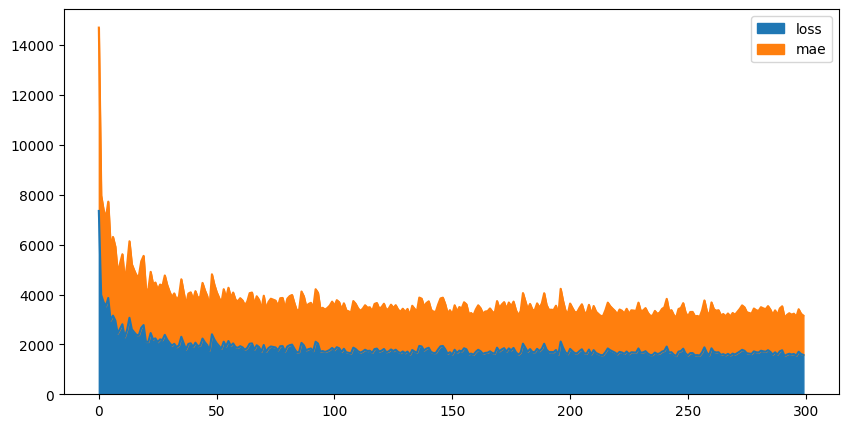

In [140]:
results[79], pd.DataFrame(results[79]["data"][0].history).plot(kind="area")